<a href="https://colab.research.google.com/github/talentrics/NWU_MSDS422_Assignments/blob/master/Assignment5_MultiClass_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MSDS 422 Muilti Class Models using Random Forest and MNIST Data set

**by Daniel Macdonald @talentrics**

**Description**

This is the 5th assignment in NWU MSDS 422 - Practical Machine Learning

text: initial source code from Aurelien Geron 'Machine Learning with SciKit Learn' Ch. 3, 7 & 8
https://github.com/ageron/handson-ml

Data Source https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat

CoLab Shared Link - this notebook https://colab.research.google.com/drive/1M7hXbshwybEKlUcf3RgrDKbCrr_NLa9U

GitHub Repository https://github.com/talentrics/MSDS422_Assignment5

**Table of contents:**

*   System & Data Setup (MNIST)
*   Model 1: Random Forest Fit w/ out PCA
*   Principal Component Analysis
*   Model 2: Random Forest w/ reduced data set
*   Analysis of F1 & Precision/Recall Model 1 & 2
*   Model 3: re-run Model 2 with only 'training' PCA
*   Conclusion

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib # import matplotlib
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### MNIST Data Set

In [0]:
#install PyDrive to pull in csv data
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# https://drive.google.com/file/d/1h35Iv1pgqAnAV7lUywEZq-P3O4VLj9Q3/view?usp=sharing

#download survey data from google drive
downloaded1 = drive.CreateFile({'id': '1h35Iv1pgqAnAV7lUywEZq-P3O4VLj9Q3'})
downloaded1.GetContentFile('mnist-original.mat')

In [6]:
from scipy.io import loadmat

mnist_path = "mnist-original.mat"
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
    }
print("Success!")

Success!


In [13]:
#check data
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [8]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [15]:
y.shape

(70000,)

### Plot digits and check data

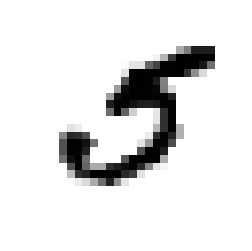

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

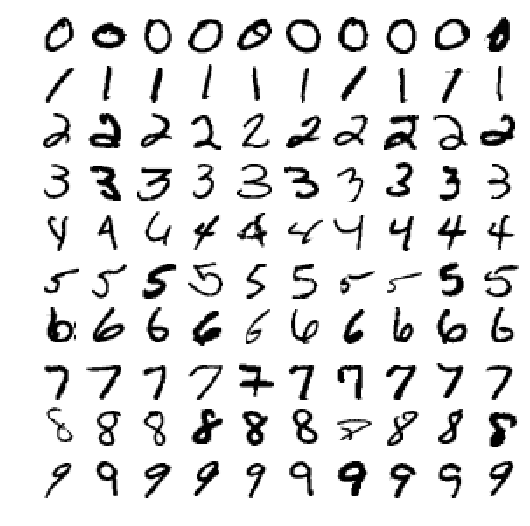

In [19]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [0]:
y[36000]

### Split train/test

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [21]:
y_test.shape

(10000,)

In [0]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 1) Random Forest Classifier - all variables

In [23]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=784)
clf.fit(X_train, y_train)
print("Success!")

Success!
CPU times: user 9min 2s, sys: 1.92 s, total: 9min 4s
Wall time: 9min 5s


In [26]:
%%time
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(clf, X_train, y_train)

CPU times: user 16min 49s, sys: 14.7 s, total: 17min 4s
Wall time: 17min 4s


In [27]:
y_scores.shape

(60000,)

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                                classification_report, confusion_matrix
print(f1_score(y_train, y_scores, average="macro"))
print(precision_score(y_train, y_scores, average="macro"))
print(recall_score(y_train, y_scores, average="macro"))    

0.9674553643131226
0.9674689600077648
0.9674664223581528


In [30]:
%%time
y_test_scores = cross_val_predict(clf, X_test, y_test)
y_test.shape

CPU times: user 1min 42s, sys: 133 ms, total: 1min 42s
Wall time: 1min 42s


In [31]:
print(f1_score(y_test, y_test_scores, average="macro"))
print(precision_score(y_test, y_test_scores, average="macro"))
print(recall_score(y_test, y_test_scores, average="macro"))   

0.9436560321870724
0.9439590234429825
0.9435210446290615


In [0]:
sns.residplot(y_test, y_test_scores, lowess=True, color="g")

In [32]:
from sklearn.metrics import confusion_matrix
conf_mx1 = confusion_matrix(y_test, y_test_scores)
conf_mx1

array([[ 962,    0,    2,    0,    0,    3,    6,    1,    6,    0],
       [   0, 1122,    2,    3,    0,    3,    2,    1,    2,    0],
       [   9,    0,  965,    9,   13,    1,    8,   18,    8,    1],
       [   1,    1,   20,  940,    0,   17,    0,   13,   13,    5],
       [   2,    2,    2,    0,  930,    1,    5,    0,    4,   36],
       [   7,    5,    2,   25,    6,  815,   12,    3,    9,    8],
       [  12,    4,    3,    0,    4,    6,  925,    0,    4,    0],
       [   2,   13,   22,    1,    8,    1,    0,  957,    2,   22],
       [   5,    5,    6,   15,    6,    7,    5,    3,  908,   14],
       [   8,    7,    5,   12,   27,    3,    1,   10,   18,  918]])

In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

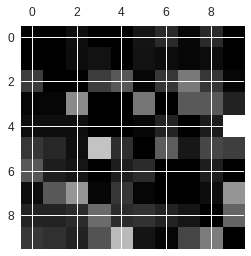

In [34]:
row_sums = conf_mx1.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx1 / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## 2) PCA analysis - dimension reduction

In [12]:
%%time
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(mnist["data"])
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

CPU times: user 30.6 s, sys: 2.3 s, total: 32.9 s
Wall time: 18.4 s


In [36]:
d

154

## 3) Random Forest reduced data set

In [61]:
%%time
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

CPU times: user 20.3 s, sys: 3.73 s, total: 24 s
Wall time: 12.7 s


In [43]:
X_reduced.shape

(60000, 154)

In [46]:
%%time
clf_2 = RandomForestClassifier(n_estimators=154)
clf_2.fit(X_reduced, y_train)
print("Success!")

Success!
CPU times: user 3min 16s, sys: 607 ms, total: 3min 16s
Wall time: 3min 16s


In [50]:
%%time
y_scores_2 = cross_val_predict(clf_2, X_reduced, y_train)

CPU times: user 5min 49s, sys: 325 ms, total: 5min 49s
Wall time: 5min 49s


In [51]:
y_scores_2.shape

(60000,)

In [52]:
print(f1_score(y_train, y_scores_2, average="macro"))
print(precision_score(y_train, y_scores_2, average="macro"))
print(recall_score(y_train, y_scores_2, average="macro")) 

0.9441314141124069
0.9442049424735097
0.9441563075372048


In [53]:
y_test_scores_2 = cross_val_predict(clf_2, X_test_reduced, y_test)
y_test.shape

(10000,)

In [54]:
print(f1_score(y_test, y_test_scores_2, average="macro"))
print(precision_score(y_test, y_test_scores_2, average="macro"))
print(recall_score(y_test, y_test_scores_2, average="macro")) 

0.9073518317695063
0.9077337425582691
0.9073785313402312


In [55]:
conf_mx2 = confusion_matrix(y_test, y_test_scores_2)
conf_mx2

array([[ 950,    0,    4,    2,    1,    6,    9,    1,    7,    0],
       [   0, 1103,   10,    4,    1,    0,    4,    2,   11,    0],
       [  17,    3,  939,   10,   18,    0,    4,   14,   23,    4],
       [   3,    3,   32,  900,    1,   22,    2,    8,   26,   13],
       [   1,    6,    7,    2,  888,    4,   19,    5,    7,   43],
       [  12,    3,    4,   52,   13,  762,   16,    2,   22,    6],
       [  12,    6,    6,    0,    9,   11,  912,    0,    2,    0],
       [   5,   21,   23,    3,   10,    2,    0,  935,    4,   25],
       [  11,    2,   22,   30,   17,   31,    2,   14,  834,   11],
       [  10,    8,    8,   12,   53,   10,    2,   34,    9,  863]])

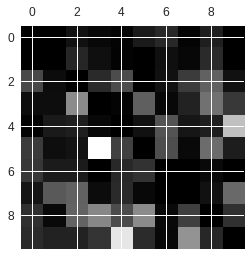

In [56]:
row_sums2 = conf_mx2.sum(axis=1, keepdims=True)
norm_conf_mx2 = conf_mx2 / row_sums2
np.fill_diagonal(norm_conf_mx2, 0)
plt.matshow(norm_conf_mx2, cmap=plt.cm.gray)
plt.show()

## 4) Model comparison & timing

**Model 1 -** Random Forest Classifier (n_estimators = 784)
> time to run & test: ~27 mins; F1 & Precision Scores (train/test) .96/.94

**Model 2** - Random Forest Classifier (n_estimators = 154)
> time to run & test: ~10 mins; F1 & Precision Scores (train/test) .94/.90
> *design flaw within PCA creation (full data set instead of train data)

**Model 3 -** Random Forest Classifier (n_estimators = 149) **recommended model <----**
> time to run & test: ~10 mins; F1 & Precision Scores (train/test) .94/.90




## 5) re-run dimension reduction on training data & re-run model

In [0]:
pca_2 = PCA()
pca_2.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d2 = np.argmax(cumsum >= 0.95) + 1

In [14]:
d2

154

In [65]:
np.sum(pca_2.explained_variance_ratio_)

1.0

In [15]:
%%time
pca_3 = PCA(n_components = 149)
X_train_reduced_3 = pca_3.fit_transform(X_train)
X_test_reduced_3 = pca_3.fit_transform(X_test)

CPU times: user 23.6 s, sys: 3.89 s, total: 27.5 s
Wall time: 14.5 s


In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf_3 = RandomForestClassifier(n_estimators=149)
clf_3.fit(X_train_reduced_3, y_train)
print("Success!")

Success!
CPU times: user 3min 10s, sys: 55.8 ms, total: 3min 10s
Wall time: 3min 10s


In [19]:
%%time
from sklearn.model_selection import cross_val_predict
y_train_scores_3 = cross_val_predict(clf_3, X_train_reduced_3, y_train)
y_test_scores_3 = cross_val_predict(clf_3, X_test_reduced_3, y_test)

CPU times: user 6min 8s, sys: 2.11 s, total: 6min 10s
Wall time: 6min 10s


In [71]:
print(f1_score(y_train, y_train_scores_3, average="macro"))
print(precision_score(y_train, y_train_scores_3, average="macro"))
print(recall_score(y_train, y_train_scores_3, average="macro")) 

0.9439024033718333
0.9439590358045074
0.9439303255141368


In [72]:
print(f1_score(y_test, y_test_scores_3, average="macro"))
print(precision_score(y_test, y_test_scores_3, average="macro"))
print(recall_score(y_test, y_test_scores_3, average="macro")) 

0.9074937632623261
0.9080615868633707
0.9074071567613704


In [20]:
from sklearn.metrics import confusion_matrix
conf_mx3 = confusion_matrix(y_test, y_test_scores_3)
conf_mx3

array([[ 949,    0,    6,    3,    1,    5,   10,    1,    5,    0],
       [   0, 1098,   13,    4,    0,    0,    4,    2,   14,    0],
       [  13,    3,  931,   13,   19,    1,    5,   15,   26,    6],
       [   2,    2,   31,  905,    2,   20,    4,   11,   28,    5],
       [   1,    4,    5,    0,  882,    4,   22,    9,    9,   46],
       [  11,    3,    8,   51,   11,  762,   16,    2,   21,    7],
       [  13,    4,    9,    0,    5,   12,  913,    0,    2,    0],
       [   4,   18,   24,    3,    8,    1,    2,  942,    2,   24],
       [   9,    2,   15,   30,   13,   22,    7,    8,  859,    9],
       [  15,    7,    6,   12,   56,    7,    2,   32,   10,  862]])

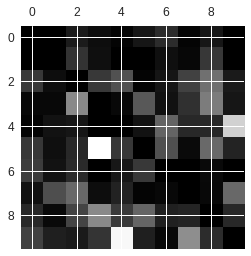

In [24]:
row_sums3 = conf_mx3.sum(axis=1, keepdims=True)
norm_conf_mx3 = conf_mx3 / row_sums3
np.fill_diagonal(norm_conf_mx3, 0)
plt.matshow(norm_conf_mx3, cmap=plt.cm.gray)
plt.show()

# Conclusion

**Recommendation to reduce data dimensions using PCA on the training data set (model 3).**  Resulting Random Forest model uses 149 estimators.  The F1 and Precision scores of the recommended model are .94 accuracy on the training data, and .90 accuracy on the test data.  The time it takes to run the model is ~10 minutes, which is a 66% reduction in timing for a slightly improved test result (model 1).